In [3]:
import numpy as np
import os
import pandas as pd
import h5py

from astrometry.util.fits import fits_table, merge_tables

# To plot pretty figures
%matplotlib inline
#%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from obiwan.qa.visual import readImage,sliceImage,plotImage, flux2mag

ModuleNotFoundError: No module named 'skimage'

# elg_dr5_coadds: 1126p220

In [16]:
brick='1126p220'
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata/elg_dr5_coadds/hdf5',brick[:3],brick)

f= h5py.File(os.path.join(DATA_DIR,
                      'img_ivar_grz.hdf5'),
                    'r')
f_onedge= h5py.File(os.path.join(DATA_DIR,
                      'img_ivar_grz_onedge.hdf5'),
                    'r')

print(len(f.keys()),len(f_onedge.keys()))

(273, 0)


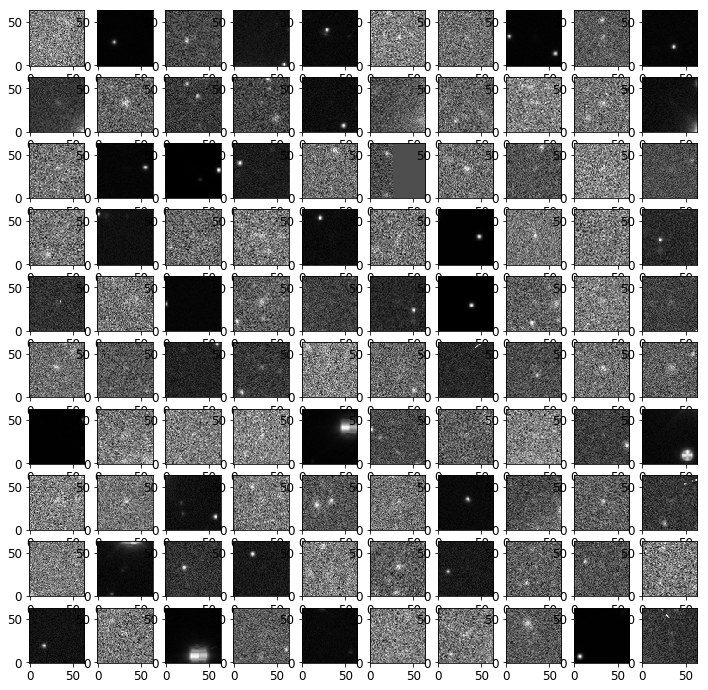

In [17]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,2],ax[row,col],qs=None)

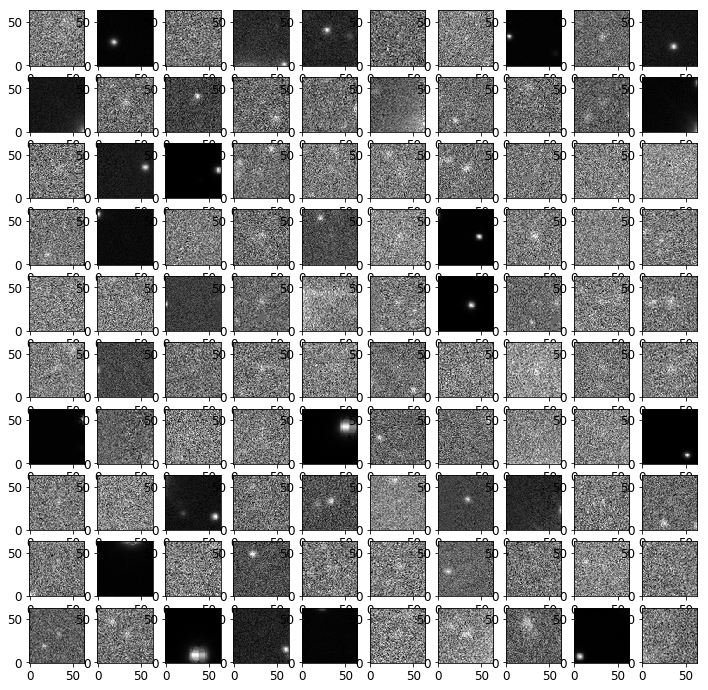

In [18]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,0],ax[row,col],qs=None)

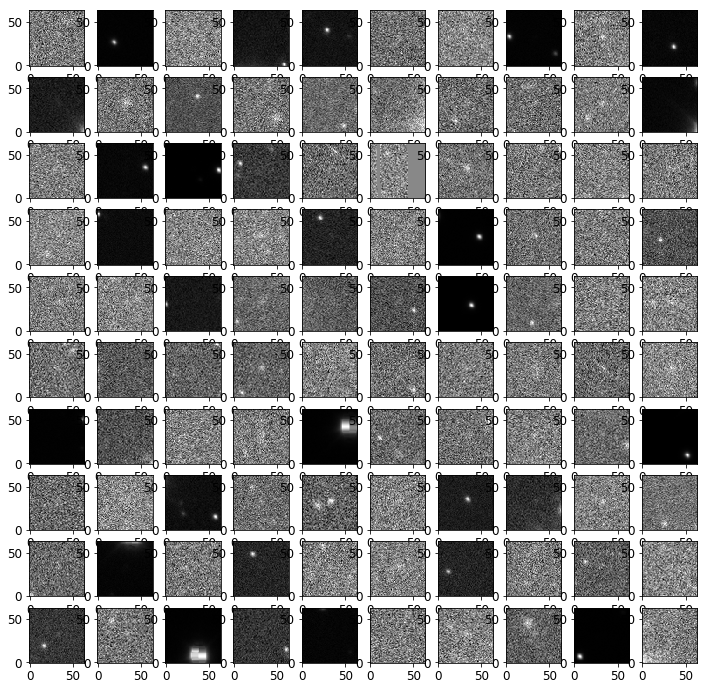

In [19]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,1],ax[row,col],qs=None)

# DR5 sources: 1126p220

### First apply the same set of cuts to real sources

In [39]:
def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)

def get_xy_pad(slope,pad):
    """Returns dx,dy"""
    theta= np.arctan(abs(slope))
    return pad*np.sin(theta), pad*np.cos(theta)

def y1_line(rz,pad=None):
    slope,yint= 1.15,-0.15
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz+dx) + yint + dy
    else:
        return slope*rz + yint
    
def y2_line(rz,pad=None):
    slope,yint= -1.2,1.6
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz-dx) + yint + dy
    else:
        return slope*rz + yint
    
def get_ELG_box(rz,gr, pad=None):
    """
    Args:
        rz: r-z
        gr: g-r
        pad: magnitudes of padding to expand TS box
    """
    x1,y1= rz,y1_line(rz)
    x2,y2= rz,y2_line(rz)
    x3,y3= np.array([0.3]*len(rz)),gr
    x4,y4= np.array([1.6]*len(rz)),gr
    if pad:
        dx,dy= get_xy_pad(1.15,pad)
        x1,y1= x1-dx,y1+dy
        dx,dy= get_xy_pad(-1.2,pad)
        x2,y2= x2+dx,y2+dy
        x3 -= pad
        x4 += pad
    return dict(x1=x1, y1=y1,
                x2=x2, y2=y2,
                x3=x3, y3=y3,
                x4=x4, y4=y4)



In [40]:
tractor=fits_table(os.path.join(os.environ['HOME'],
                     'mydata/dr5_cutouts','tractor',
                     brick[:3],'tractor-%s.fits' % brick))

/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


1587 3748


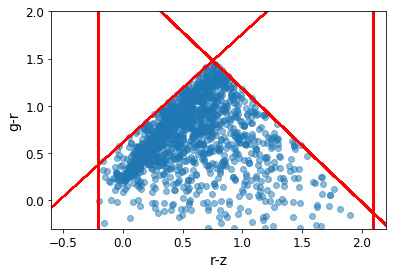

In [51]:
d= {}
for b in 'grz':
    d[b]= flux2mag(tractor.get('flux_'+b)/tractor.get('mw_transmission_'+b))
df= pd.DataFrame(d)
df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5) & 
        (df['r-z'] <= 1.6 + 0.5))

fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)

pad= get_ELG_box(df['r-z'].values,df['g-r'].values,pad=0.5)
ax.plot(pad['x1'],pad['y1'],'r--')
ax.plot(pad['x2'],pad['y2'],c='r',ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c='r',ls='--',lw=2)
ax.plot(pad['x4'],pad['y4'],c='r',ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

print(len(df[inBox])),len(df)

In [44]:
print(set(tractor.type))

set(['PSF ', 'COMP', 'EXP ', 'DEV ', 'REX '])


In [88]:
# Drop comp, dev and set rhalf to whats left
fwhm_or_rhalf= np.zeros(len(tractor))-1 # arcsec
isPSF= np.char.strip(tractor.type) == 'PSF'
isEXP= pd.Series(np.char.strip(tractor.type)).isin(['EXP','REX'])
isDEV= np.char.strip(tractor.type) == 'DEV'
isCOMP= np.char.strip(tractor.type) == 'COMP'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([tractor[isPSF].psfsize_g,
                                        tractor[isPSF].psfsize_r,
                                        tractor[isPSF].psfsize_z]),axis=0)/2
fwhm_or_rhalf[isEXP]= tractor[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= tractor[isDEV].shapedev_r
df['fwhm_or_rhalf']= fwhm_or_rhalf

grz_gt0= ((tractor.flux_g > 0) &
          (tractor.flux_r > 0) &
          (tractor.flux_z > 0) &
          (tractor.flux_ivar_g > 0) &
          (tractor.flux_ivar_r > 0) &
          (tractor.flux_ivar_z > 0))

keep= ((grz_gt0) & 
       (isCOMP == False) &
       (isDEV == False) &
       (df['fwhm_or_rhalf'] < 5)) 

print(len(tractor[keep])),len(tractor)

3068 3748


In [54]:
#Last cut
rhalf_lim= (0.262/2,2.) # Camera, Data
g,r,z= tuple(np.array([24.0,23.4,22.5])+0.5)
bad= ((df['fwhm_or_rhalf'] < rhalf_lim[0]) |
      (df['fwhm_or_rhalf'] > rhalf_lim[1]) |
      (df['z'] >= z) | #beyond mag limit
      (df['r'] >= r) |
      (df['g'] >= g))

print(len(tractor[bad == False])),len(tractor)

2445 3748


In [56]:
final= (inBox) & (keep) & (bad == False)
print(len(tractor[final])),len(tractor)

1303 3748


In [59]:
df['z'].describe()

count    3695.000000
mean             inf
std              NaN
min         8.724962
25%        19.958212
50%        21.436197
75%        22.336040
max              inf
Name: z, dtype: float64

# Compare final real sample to the 10k deep2/dr3 sample

In [71]:
# cut on min grz mag in 10k sample
samp_10k= fits_table(os.path.join(os.environ['HOME'],
                                  'mydata/elg_dr5_coadds',
                                  'elg_sample_5dim_10k.fits'))
samp_10k.get_columns()

['id', 'rhalf', 'redshift', 'z', 'r', 'g']

{'r': 20.465867038084912, 'z': 19.439093313737203, 'g': 20.676581767403892}


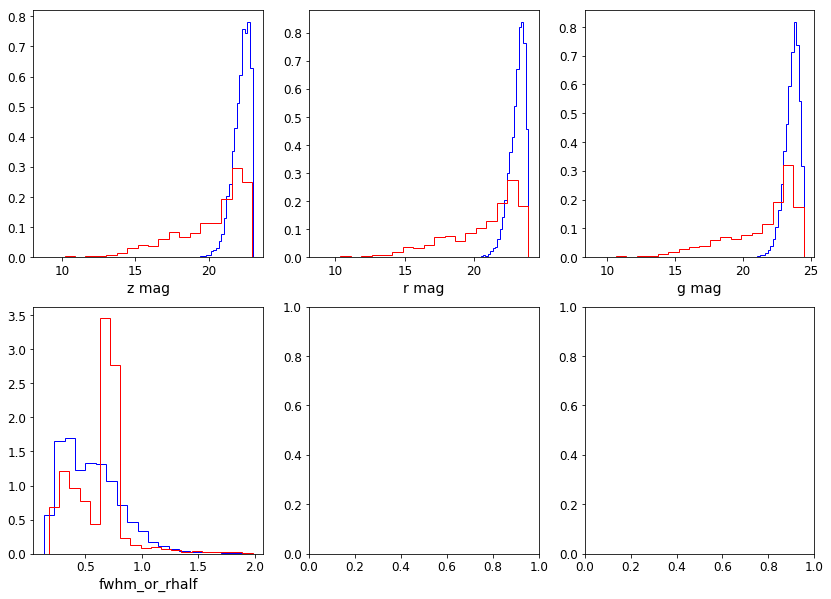

In [76]:
fig,ax= plt.subplots(2,3,figsize=(14,10))

_,bins,_= ax[0,0].hist(samp_10k.get('z'),bins=20,histtype='step',color='b',normed=True)
_=ax[0,0].hist(df.loc[final,'z'],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_,bins,_= ax[0,1].hist(samp_10k.get('r'),bins=20,histtype='step',color='b',normed=True)
_=ax[0,1].hist(df.loc[final,'r'],bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_,bins,_= ax[0,2].hist(samp_10k.get('g'),bins=20,histtype='step',color='b',normed=True)
_=ax[0,2].hist(df.loc[final,'g'],bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')

_,bins,_= ax[1,0].hist(samp_10k.get('rhalf'),bins=20,histtype='step',color='b',normed=True)
_=ax[1,0].hist(df.loc[final,'fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('fwhm_or_rhalf')

min_mag={b:samp_10k.get(b).min()
         for b in 'grz'}
print(min_mag)

# Stellar contamination?
* when bright sources removed at hard threshold, there are nearly no fainter ones there, so this seems to suggest fainter popoulation is galaxies while brighter one is stars

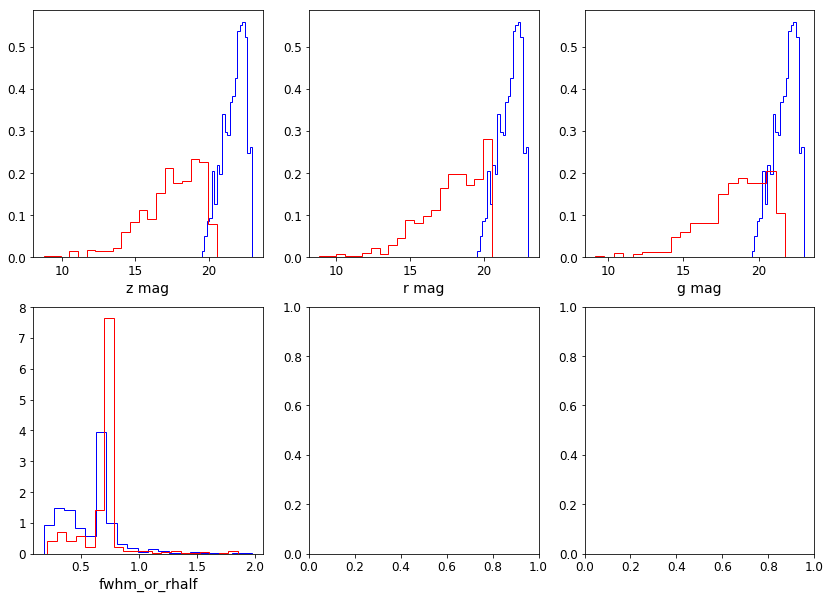

In [81]:
isFaint= ((df['g'] >= min_mag['g']) &
          (df['r'] >= min_mag['r']) &
          (df['z'] >= min_mag['z']))
final_faint= final & isFaint
final_bright= final & (isFaint == False)

fig,ax= plt.subplots(2,3,figsize=(14,10))

_,bins,_= ax[0,0].hist(df.loc[final_faint,'z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,0].hist(df.loc[final_bright,'z'],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_,bins,_= ax[0,1].hist(df.loc[final_faint,'z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,1].hist(df.loc[final_bright,'r'],bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_,bins,_= ax[0,2].hist(df.loc[final_faint,'z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,2].hist(df.loc[final_bright,'g'],bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')

_,bins,_= ax[1,0].hist(df.loc[final_faint,'fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[1,0].hist(df.loc[final_bright,'fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('fwhm_or_rhalf')


# Now look at them 

## the above cuts are applied when creating the cutouts...

In [89]:
brick='1126p220'
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata/dr5_hdf5/hdf5',brick[:3],brick)

f= h5py.File(os.path.join(DATA_DIR,
                      'img_ivar_grz.hdf5'),
                    'r')
f_onedge= h5py.File(os.path.join(DATA_DIR,
                      'img_ivar_grz_onedge.hdf5'),
                    'r')

print(len(f.keys()),len(f_onedge.keys()))

(796, 0)


In [95]:
# Numbers agree, so applied cuts when making cutous seems to have worked!
extra_cut= ((tractor.brick_primary) &
            (tractor.nobs_g >= 1) &
            (tractor.nobs_r >= 1) &
            (tractor.nobs_z >= 1))
print(len(tractor[final_faint]),len(tractor[final_faint & extra_cut ]), len(f.keys()))

(816, 796, 796)


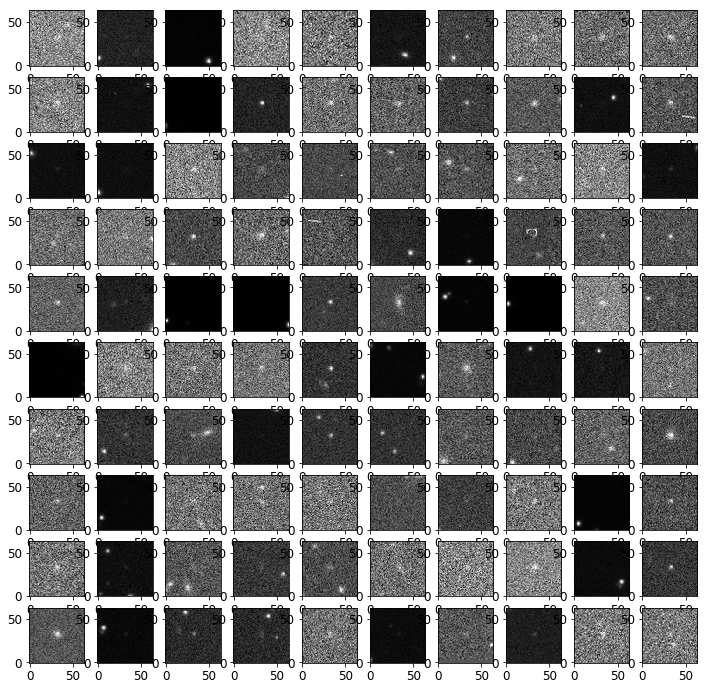

In [99]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,2],ax[row,col],qs=None)

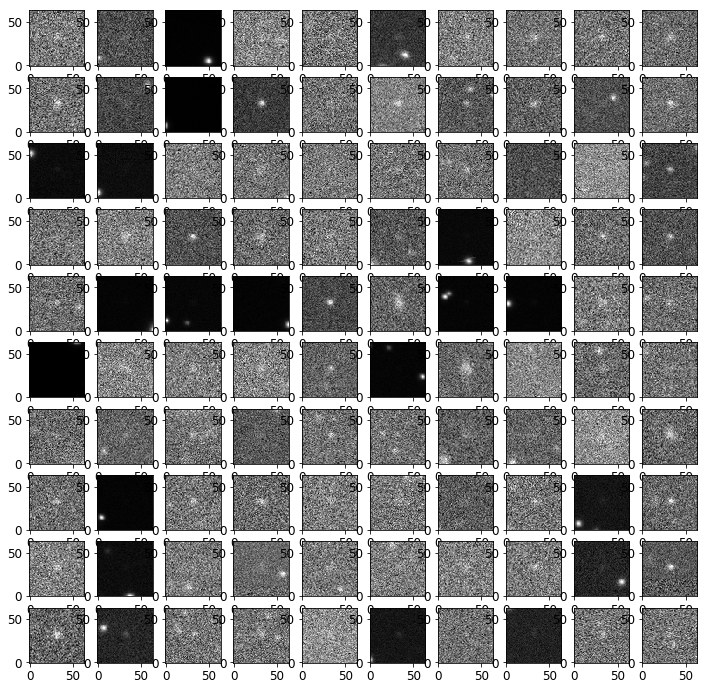

In [97]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,0],ax[row,col],qs=None)

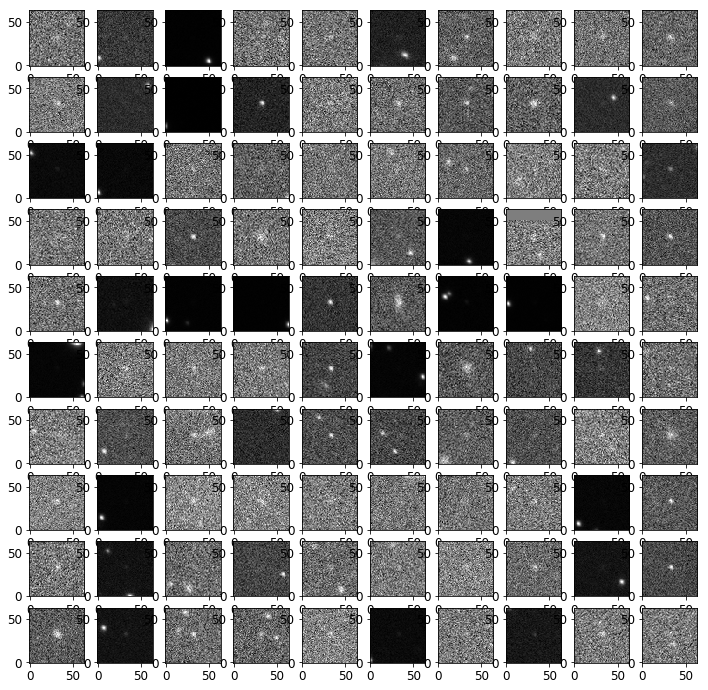

In [98]:
nrow,ncol=10,10
fig,ax= plt.subplots(nrow,ncol,figsize=(12,12))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= f.items()[i][0]
        plotImage().imshow(f[key+'/img'][...,1],ax[row,col],qs=None)

# TODO
* How identify images that overlap 1 ccd edge but other bands ok? want to throw these out
* How flag if bright real source is near the simulated source?


# Full brick: 1828p062

In [3]:
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata/hdf5_cutouts/elg_100deg2/elg')
brick='1828p062'
hdf5_obj= h5py.File(os.path.join(DATA_DIR,
                      '%s/%s' % (brick[:3],brick),
                      'img_ivar_grz.hdf5'),
                    'r')
hdf5_obj_onedge= h5py.File(os.path.join(DATA_DIR,
                      '%s/%s' % (brick[:3],brick),
                      'img_ivar_grz_onedge.hdf5'),
                    'r')

coadd_g= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-g.fits.fz' % brick))
coadd_r= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-r.fits.fz' % brick))
coadd_z= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-z.fits.fz' % brick))

sims_z= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-sims-z.fits.fz' % brick))

simcat= fits_table(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/obiwan',
                     'simcat-elg-%s.fits' % brick))



<IPython.core.display.Javascript object>


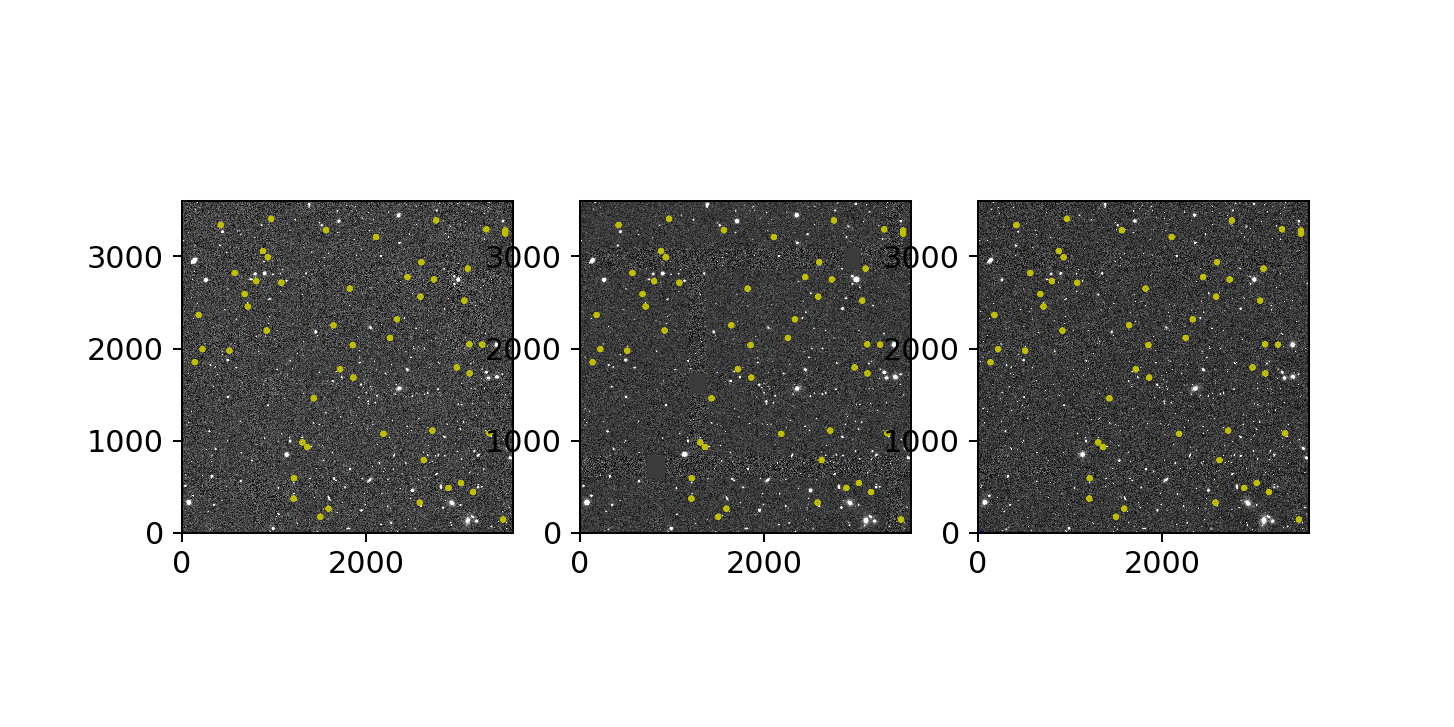

In [32]:
fig,ax= plt.subplots(1,3,figsize=(8,4))
plotImage().imshow(coadd_g,ax[0])
plotImage().imshow(coadd_r,ax[1])
plotImage().imshow(coadd_z,ax[2])
for i in range(3):
    plotImage().circles(simcat.x,simcat.y,ax[i],
                        img_shape=coadd_g.shape)

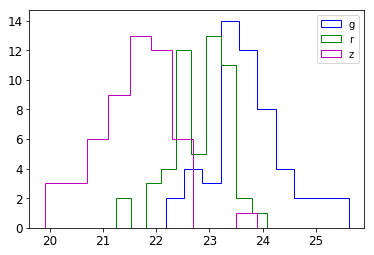

In [43]:
def flux2mag(flux):
    return -2.5*np.log10(1e-9 * flux)

%matplotlib inline
for b,col in zip('grz','bgm'):
    _=plt.hist(flux2mag(simcat.get(b+'flux')),color=col,histtype='step',label=b)
plt.legend()
#_=plt.hist(flux2mag(simcat.gflux),color='b',histtype='step')
#_=plt.hist(flux2mag(simcat.gflux),color='b',histtype='step')

In [9]:
#hdf5_obj.items(), hdf5_obj_onedge.items()

In [46]:
len(hdf5_obj.items())

53

IndexError: list index out of range

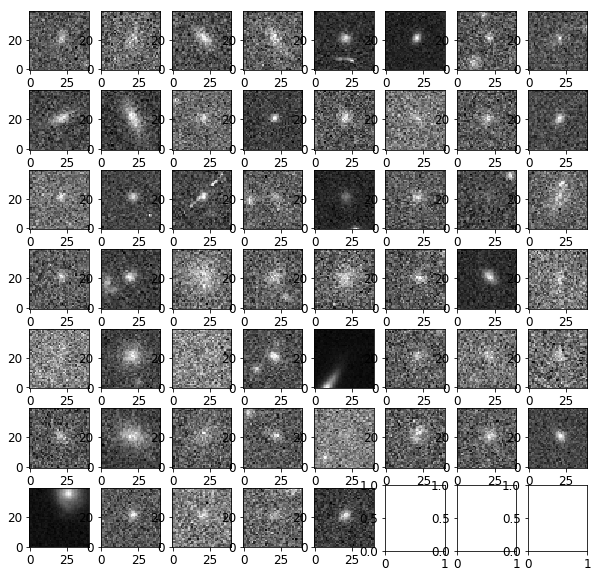

In [47]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,2],ax[row,col],qs=None)

IndexError: list index out of range

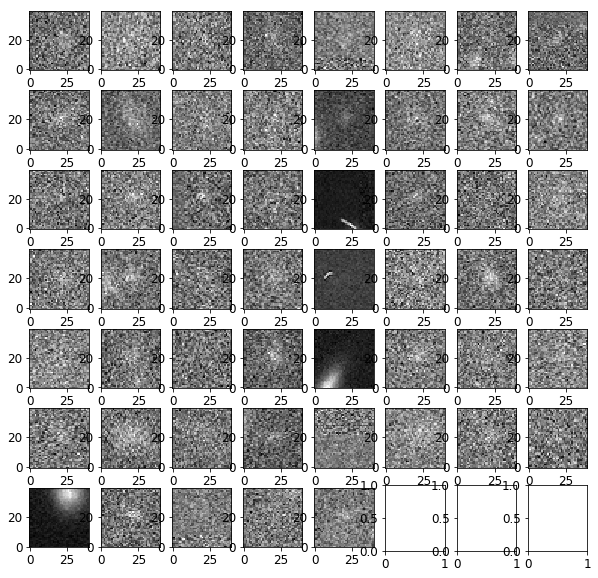

In [48]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,1],ax[row,col],qs=None)

IndexError: list index out of range

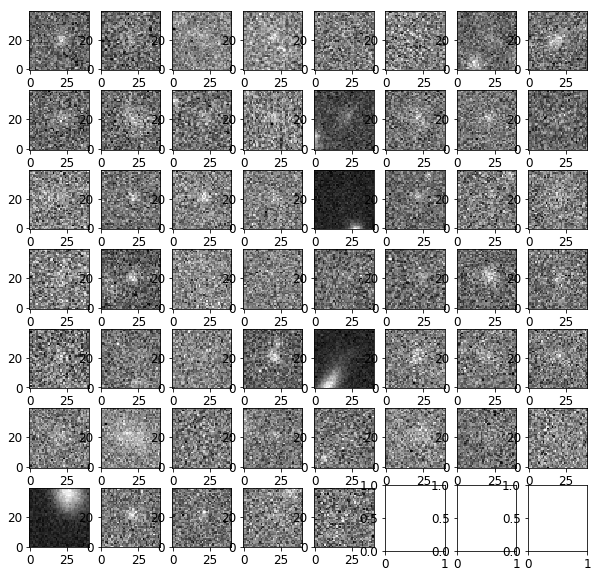

In [66]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,0],ax[row,col],qs=None)

<IPython.core.display.Javascript object>


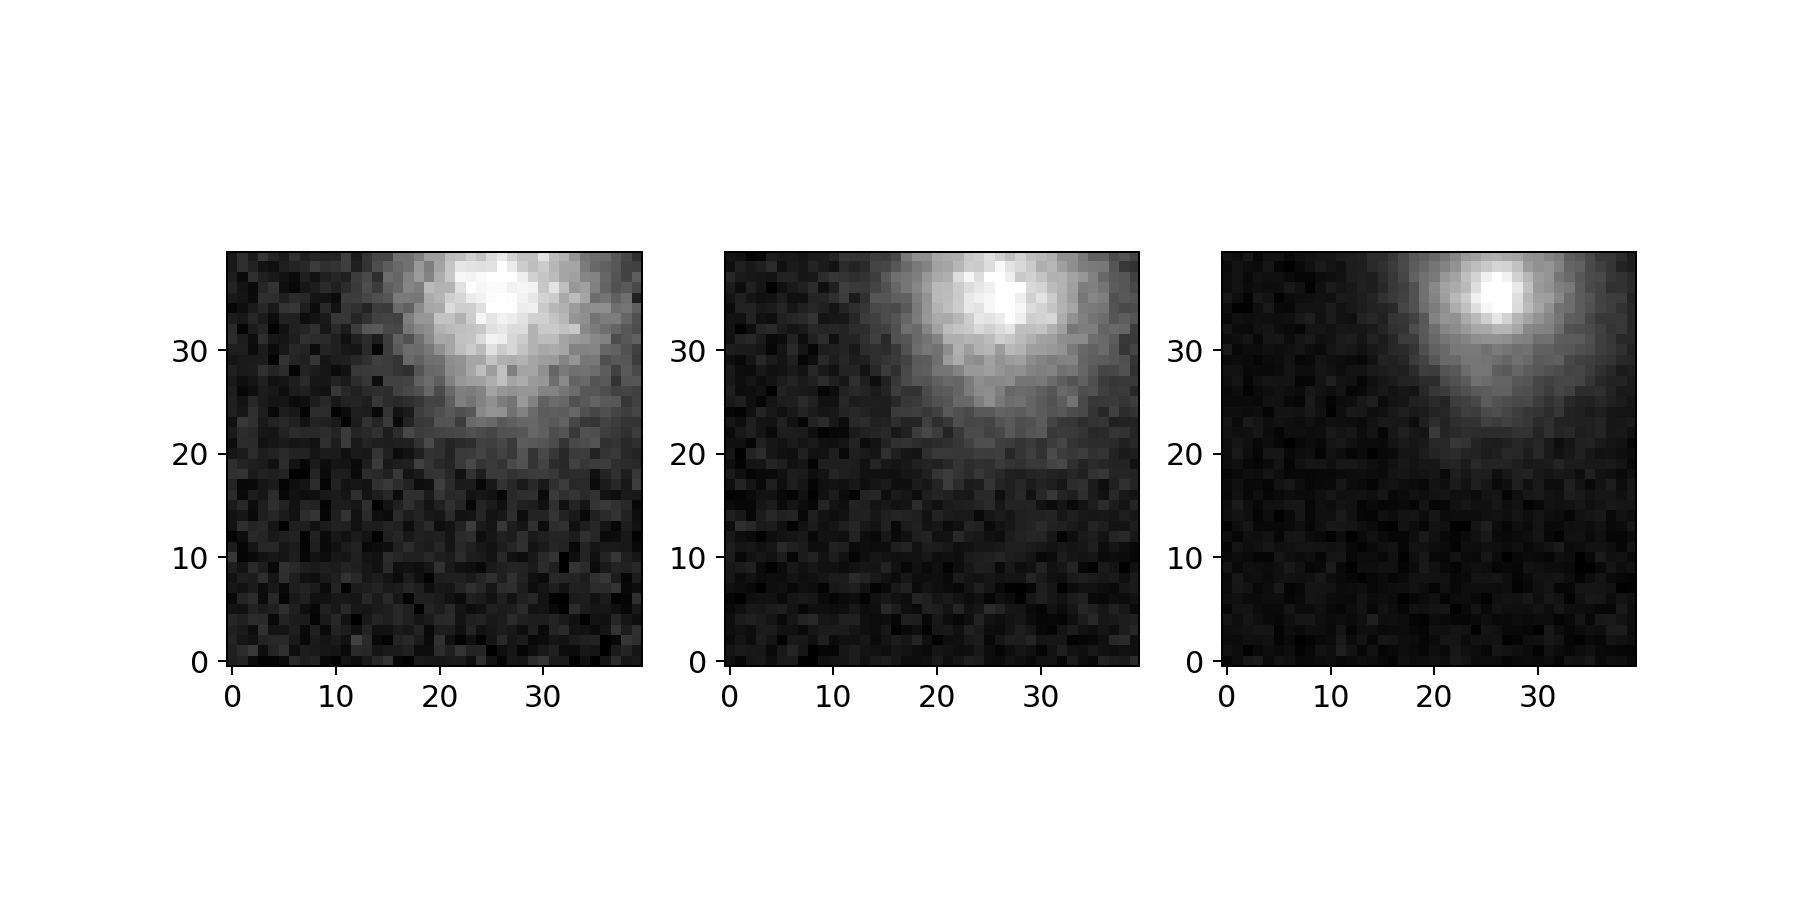

934639


In [4]:
fig,ax= plt.subplots(1,3,figsize=(10,5))
key= hdf5_obj.items()[-5][0]
print(key)
for i in range(3):
    plotImage().imshow(hdf5_obj[key+'/img'][...,i],ax[i])

<IPython.core.display.Javascript object>


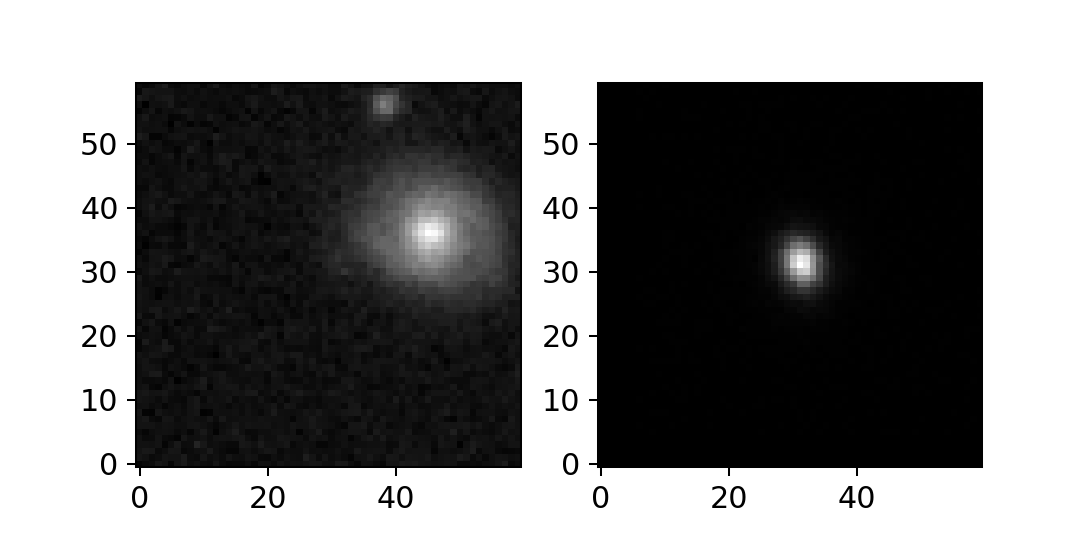

In [6]:
%matplotlib notebook
i= simcat.id == int(key)
fig,ax= plt.subplots(1,2,figsize=(6,3))
hw=30
x,y= int(simcat[i].x),int(simcat[i].y)
plotImage().imshow(sliceImage(coadd_z,
                              xslice=slice(x-hw,x+hw),
                              yslice=slice(y-hw,y+hw)),
                  ax[0],qs=None)
plotImage().imshow(sliceImage(sims_z,
                              xslice=slice(x-hw,x+hw),
                              yslice=slice(y-hw,y+hw)),
                  ax[1],qs=None)

# Full brick: 1350p052

In [53]:
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata/hdf5_cutouts/elg_100deg2/elg')
brick='1350p052'
hdf5_obj= h5py.File(os.path.join(DATA_DIR,
                      '%s/%s' % (brick[:3],brick),
                      'img_ivar_grz.hdf5'),
                    'r')
hdf5_obj_onedge= h5py.File(os.path.join(DATA_DIR,
                      '%s/%s' % (brick[:3],brick),
                      'img_ivar_grz_onedge.hdf5'),
                    'r')

coadd_g= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-g.fits.fz' % brick))
coadd_r= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-r.fits.fz' % brick))
coadd_z= readImage(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/coadd',
                     'legacysurvey-%s-image-z.fits.fz' % brick))

simcat= fits_table(os.path.join(DATA_DIR,
                     '%s/%s' % (brick[:3],brick),
                     'rs0/obiwan',
                     'simcat-elg-%s.fits' % brick))



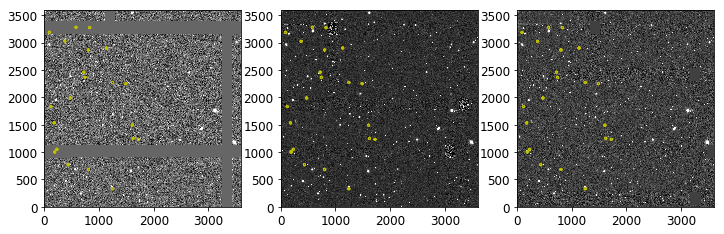

In [59]:
fig,ax= plt.subplots(1,3,figsize=(12,10))
plotImage().imshow(coadd_g,ax[0])
plotImage().imshow(coadd_r,ax[1])
plotImage().imshow(coadd_z,ax[2])
for i in range(3):
    plotImage().circles(simcat.x,simcat.y,ax[i],
                        img_shape=coadd_g.shape)

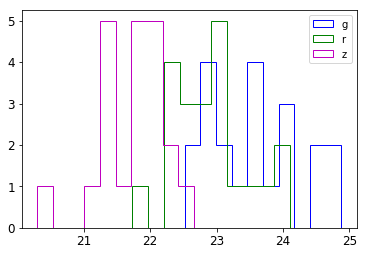

In [55]:
%matplotlib inline
for b,col in zip('grz','bgm'):
    _=plt.hist(flux2mag(simcat.get(b+'flux')),color=col,histtype='step',label=b)
plt.legend()
#_=plt.hist(flux2mag(simcat.gflux),color='b',histtype='step')
#_=plt.hist(flux2mag(simcat.gflux),color='b',histtype='step')

In [51]:
len(hdf5_obj.items())

21

IndexError: list index out of range

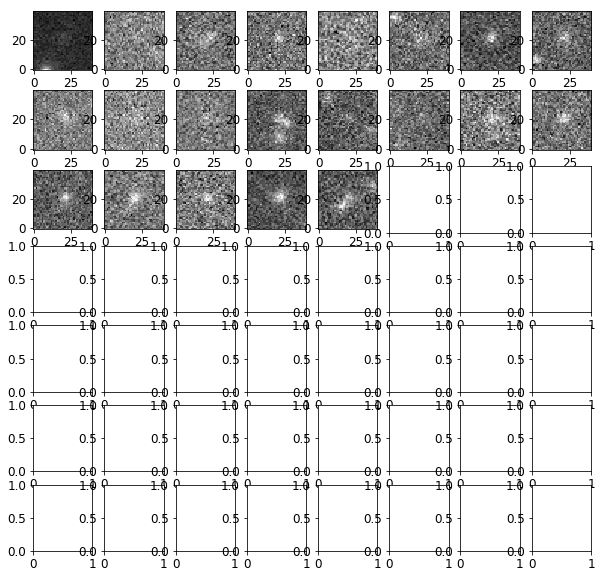

In [52]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,2],ax[row,col],qs=None)

IndexError: list index out of range

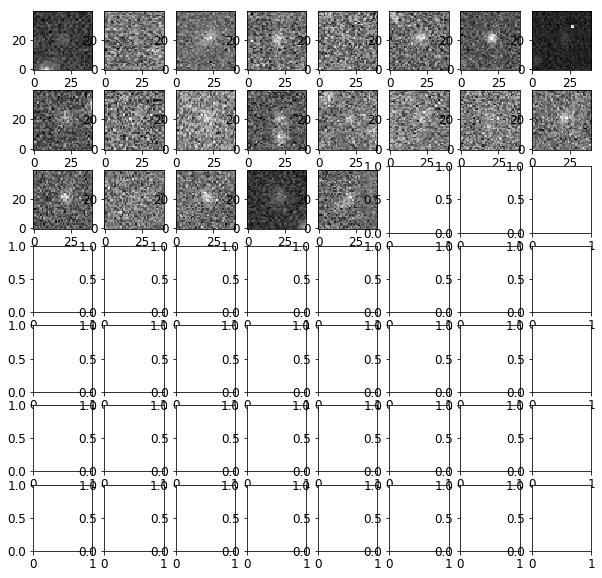

In [56]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,1],ax[row,col],qs=None)

IndexError: list index out of range

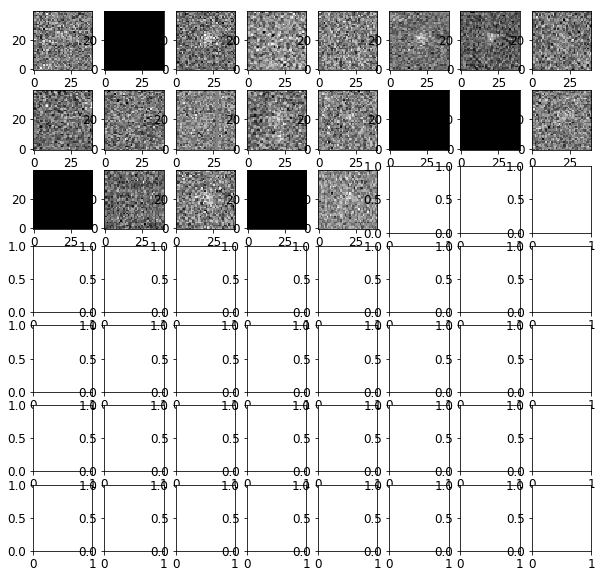

In [57]:
nrow,ncol=7,8
fig,ax= plt.subplots(nrow,ncol,figsize=(10,10))
i=-1
for row in range(nrow):
    for col in range(ncol):
        i+=1
        key= hdf5_obj.items()[i][0]
        plotImage().imshow(hdf5_obj[key+'/img'][...,0],ax[row,col],qs=None)

(0.0, 0.0)
(0.0, 0.0)


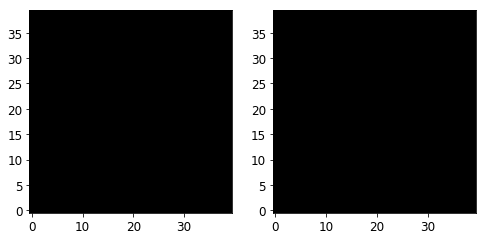

In [63]:
fig,ax= plt.subplots(1,2,figsize=(8,5))
key= hdf5_obj.items()[1][0]
plotImage().imshow(hdf5_obj[key+'/img'][...,0],ax[0],qs=None)
plotImage().imshow(hdf5_obj[key+'/ivar'][...,0],ax[1],qs=None)
print(hdf5_obj[key+'/img'][...,0].min(),hdf5_obj[key+'/img'][...,0].max())
print(hdf5_obj[key+'/ivar'][...,0].min(),hdf5_obj[key+'/ivar'][...,0].max())

# Testcase hdf5 cutouts

In [29]:
brick='0285m165'
hdf5_obj= h5py.File(os.path.join(os.environ['HOME'],
                      'myrepo/obiwan/tests/end_to_end',
                      'out_testcase_DR5_grz_elg',
                      'elg/%s/%s' % (brick[:3],brick),
                      'img_ivar_grz.hdf5'),
                    'r')
hdf5_obj_onedge= h5py.File(os.path.join(os.environ['HOME'],
                              'myrepo/obiwan/tests/end_to_end',
                              'out_testcase_DR5_grz_elg',
                              'elg/%s/%s' % (brick[:3],brick),
                              'img_ivar_grz_onedge.hdf5'),
                           'r')

In [30]:
tractor=fits_table(os.path.join(os.environ['HOME'],
                      'myrepo/obiwan/tests/end_to_end',
                      'out_testcase_DR5_grz_elg',
                      'elg/%s/%s' % (brick[:3],brick),
                      'rs0/tractor/tractor-%s.fits' % brick))


In [31]:
len(tractor), len(set(tractor.objid)), tractor.objid

(10, 10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))

In [32]:
hdf5_obj.items(), hdf5_obj_onedge.items()

([(u'1', <HDF5 group "/1" (2 members)>),
  (u'2', <HDF5 group "/2" (2 members)>),
  (u'3', <HDF5 group "/3" (2 members)>),
  (u'4', <HDF5 group "/4" (2 members)>)],
 [])

In [8]:
hdf5_obj.items(), hdf5_obj_onedge.items()

([(u'1', <HDF5 group "/1" (2 members)>),
  (u'2', <HDF5 group "/2" (2 members)>),
  (u'3', <HDF5 group "/3" (2 members)>),
  (u'4', <HDF5 group "/4" (2 members)>)],
 [])

In [9]:
hdf5_obj['/1'].items()

[(u'img', <HDF5 dataset "img": shape (40, 40, 3), type "<f4">),
 (u'ivar', <HDF5 dataset "ivar": shape (40, 40, 3), type "<f4">)]

<IPython.core.display.Javascript object>


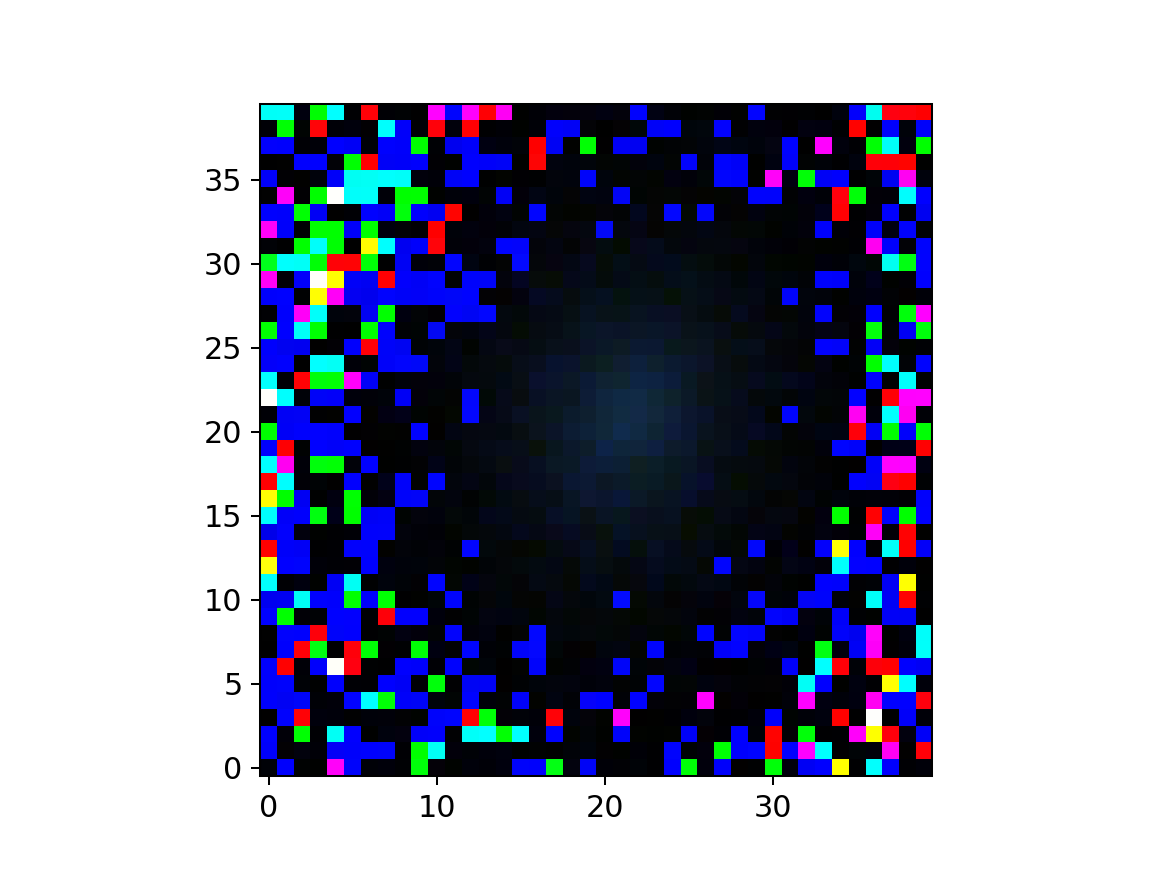

In [33]:
fig,ax= plt.subplots()
plotImage().imshow(hdf5_obj['/1/img'],ax,qs=None)

<IPython.core.display.Javascript object>


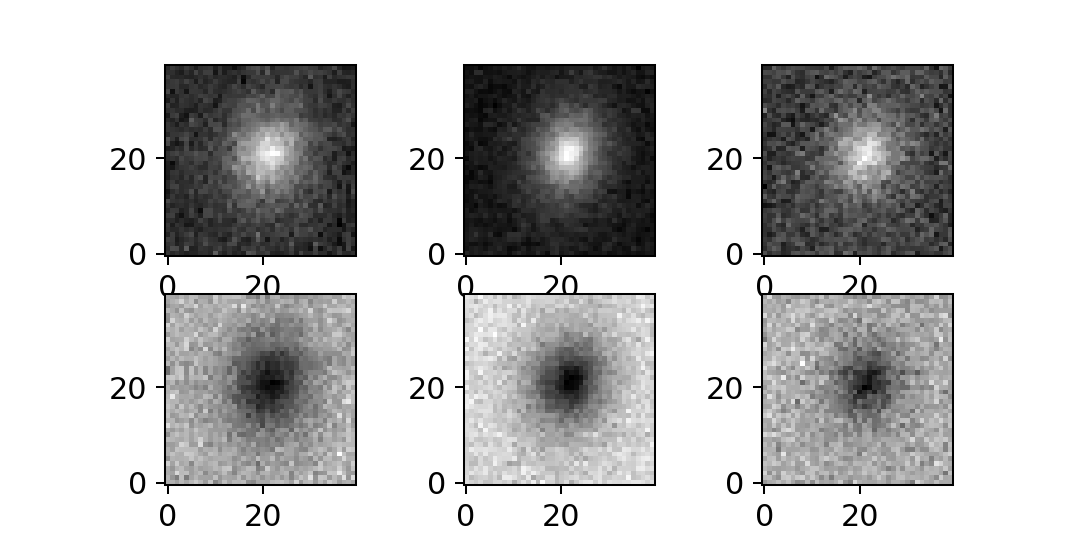

In [34]:
fig,ax= plt.subplots(2,3,figsize=(6,3))
for i in range(3):
    plotImage().imshow(hdf5_obj['/1/img'][:,:,i],ax[0,i],qs=None)
    plotImage().imshow(hdf5_obj['/1/ivar'][:,:,i],ax[1,i],qs=None)

<IPython.core.display.Javascript object>


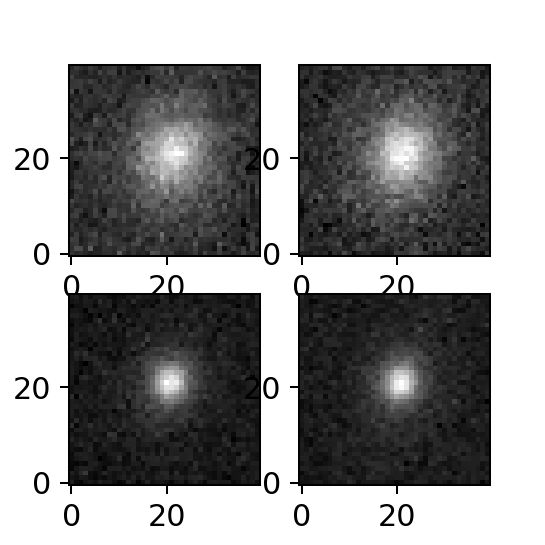

In [35]:
fig,ax= plt.subplots(2,2,figsize=(3,3))
plotImage().imshow(hdf5_obj['/1/img'][:,:,0],ax[0,0],qs=None)
plotImage().imshow(hdf5_obj['/2/img'][:,:,0],ax[0,1],qs=None)
plotImage().imshow(hdf5_obj['/3/img'][:,:,0],ax[1,0],qs=None)
plotImage().imshow(hdf5_obj['/4/img'][:,:,0],ax[1,1],qs=None)

<IPython.core.display.Javascript object>


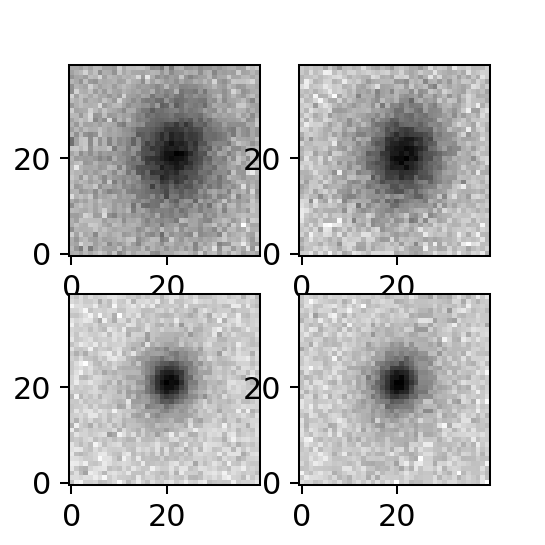

In [36]:
fig,ax= plt.subplots(2,2,figsize=(3,3))
plotImage().imshow(hdf5_obj['/1/ivar'][:,:,0],ax[0,0],qs=None)
plotImage().imshow(hdf5_obj['/2/ivar'][:,:,0],ax[0,1],qs=None)
plotImage().imshow(hdf5_obj['/3/ivar'][:,:,0],ax[1,0],qs=None)
plotImage().imshow(hdf5_obj['/4/ivar'][:,:,0],ax[1,1],qs=None)

# Onedge

In [20]:
brick='1741p242'
hdf5_obj= h5py.File(os.path.join(os.environ['HOME'],
                      'myrepo/obiwan/tests/end_to_end/out_testcase_DR5_z_onedge',
                      'elg/%s/%s' % (brick[:3],brick),
                      'img_ivar_z.hdf5'),
                    'r')
hdf5_obj_onedge= h5py.File(os.path.join(os.environ['HOME'],
                              'myrepo/obiwan/tests/end_to_end/out_testcase_DR5_z_onedge',
                              'elg/%s/%s' % (brick[:3],brick),
                              'img_ivar_z_onedge.hdf5'),
                           'r')

In [21]:
hdf5_obj.items(), hdf5_obj_onedge.items()

([],
 [(u'1', <HDF5 group "/1" (2 members)>),
  (u'2', <HDF5 group "/2" (2 members)>),
  (u'3', <HDF5 group "/3" (2 members)>),
  (u'4', <HDF5 group "/4" (2 members)>)])

In [22]:
hdf5_obj_onedge['/1'].items()

[(u'img', <HDF5 dataset "img": shape (41, 41, 1), type "<f8">),
 (u'ivar', <HDF5 dataset "ivar": shape (41, 41, 1), type "<f8">)]

In [25]:
hdf5_obj_onedge['/1/img'][:,:,0].shape

(41, 41)

<IPython.core.display.Javascript object>


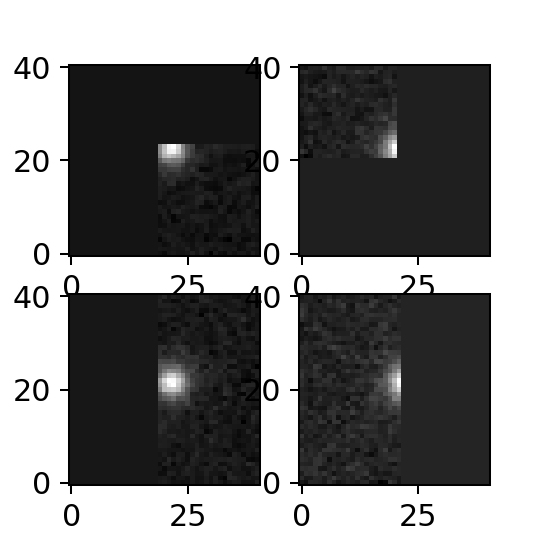

In [26]:
fig,ax= plt.subplots(2,2,figsize=(3,3))
plotImage().imshow(hdf5_obj_onedge['/1/img'][:,:,0],ax[0,0],qs=None)
plotImage().imshow(hdf5_obj_onedge['/2/img'][:,:,0],ax[0,1],qs=None)
plotImage().imshow(hdf5_obj_onedge['/3/img'][:,:,0],ax[1,0],qs=None)
plotImage().imshow(hdf5_obj_onedge['/4/img'][:,:,0],ax[1,1],qs=None)

<IPython.core.display.Javascript object>


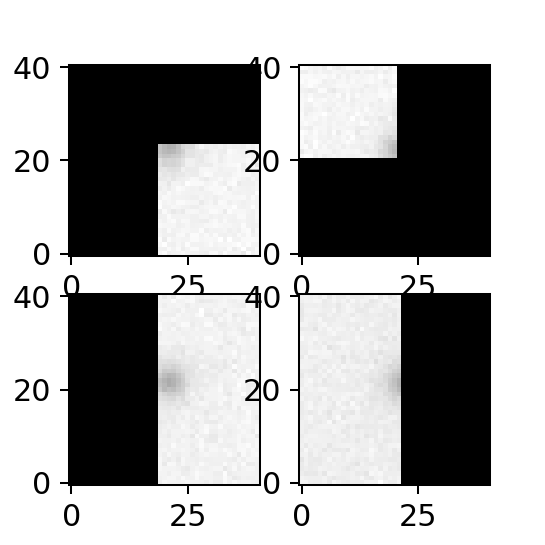

In [27]:
fig,ax= plt.subplots(2,2,figsize=(3,3))
plotImage().imshow(hdf5_obj_onedge['/1/ivar'][:,:,0],ax[0,0],qs=None)
plotImage().imshow(hdf5_obj_onedge['/2/ivar'][:,:,0],ax[0,1],qs=None)
plotImage().imshow(hdf5_obj_onedge['/3/ivar'][:,:,0],ax[1,0],qs=None)
plotImage().imshow(hdf5_obj_onedge['/4/ivar'][:,:,0],ax[1,1],qs=None)

In [28]:
fig,ax= plt.subplots(2,2,figsize=(3,3))
plotImage().imshow(hdf5_obj['/1/img'][:,:,0],ax[0,0],qs=None)
plotImage().imshow(hdf5_obj['/2/img'][:,:,0],ax[0,1],qs=None)
plotImage().imshow(hdf5_obj['/3/img'][:,:,0],ax[1,0],qs=None)
plotImage().imshow(hdf5_obj['/4/img'][:,:,0],ax[1,1],qs=None)

<IPython.core.display.Javascript object>

KeyError: 'Unable to open object (Component not found)'